# Titanic Survivor Prediction

Showcasing different classification models and their accuracy in predicting which types of passengers would survive the Titanic sinking.

![Image](https://upload.wikimedia.org/wikipedia/commons/8/82/Titanic_sinking_Wikivoyage_feature_banner.jpg)


## Feature Selection

The data set contained information about the sex and age of each passenger, which class and cabin they were in and what fare they paid, where they embarked, how many siblings/spouses they had and how many parents/children they had.

Most of the cabin data was missing, so I excluded that. The siblings/spouses and parents/children attributes were not able to be disentangled effectively, so I excluded those as well.

From where a passenger embarked shouldn't be correlated with survivability unless it's confounded by a third variable. Where the passenger embarked was slightly correlated with the fare they paid, which was highly correlated with the class they were in. I excluded the embarked location.

Age wasn't strongly correlated with survivability until the data was stratified by class.

I came up with three sets of features to try as predictors:
1. Age, sex, fare
2. Age, sex, class
3. Sex, class


## Logistic regression model

Running a logistic regression model with defaul hyperparameters using the three feature sets above yielded the highest accuracy -- 81% -- in a model where survivability was predicted by age, sex, and class.

However, I was able to improve the accuracy to 83% by stratifying the data by class and running a separate model on each class, using only sex as a predictor. The final model was:

${y}_{class1} = 2.46 - 2.94{x}_1 $

${y}_{class2} = 1.72 - 2.95{x}_1 $

${y}_{class3} = -0.01 - 2.74{x}_1 $

where ${x}_1$ indicates whether the passenger was a man (1) or a woman (0).

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score

### Data Exploration and Cleaning

In [2]:
# read in the data and preview it
df = pd.read_csv('titanic/train.csv')
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# check for misssing values
print(len(df))
df.isna().sum()

891


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [4]:
# check survivability rates by different stratifications
def check_survivor_rates(df, attribute):
    pivot_df = df[['Survived', attribute, 'PassengerId']].groupby(['Survived', attribute]).count().reset_index()
    pivot_df = pivot_df.pivot(index=attribute, columns='Survived', values='PassengerId')
    pivot_df['DidNotSurvive%'] = np.round(pivot_df[0] / (pivot_df[0] + pivot_df[1]), 2)
    pivot_df['Survive%'] = np.round(pivot_df[1] / (pivot_df[0] + pivot_df[1]), 2)
    return pivot_df

df['Sex_Pclass'] = df['Sex'] + '_' + df['Pclass'].astype(str)
print('\n', check_survivor_rates(df, 'Sex'))
print('\n', check_survivor_rates(df, 'Pclass'))
print('\n', check_survivor_rates(df, 'Sex_Pclass'))


 Survived    0    1  DidNotSurvive%  Survive%
Sex                                         
female     81  233            0.26      0.74
male      468  109            0.81      0.19

 Survived    0    1  DidNotSurvive%  Survive%
Pclass                                      
1          80  136            0.37      0.63
2          97   87            0.53      0.47
3         372  119            0.76      0.24

 Survived      0   1  DidNotSurvive%  Survive%
Sex_Pclass                                   
female_1      3  91            0.03      0.97
female_2      6  70            0.08      0.92
female_3     72  72            0.50      0.50
male_1       77  45            0.63      0.37
male_2       91  17            0.84      0.16
male_3      300  47            0.86      0.14


In [5]:
# recode sex to a boolean
df['IsMale'] = np.nan
df.loc[df['Sex'] == 'male', 'IsMale'] = 1
df.loc[df['Sex'] == 'female', 'IsMale'] = 0

In [6]:
# get dummy booleans for Embarked
df = df.join(pd.get_dummies(df['Embarked'], prefix='Embarked'))

In [7]:
# get dummy booleans for Pclass
df = df.join(pd.get_dummies(df['Pclass'], prefix='Pclass'))

In [8]:
# split sibsp
# if sibsp > 1 or age < 18 then assume siblings
# cannot assume anything for older passengers or sibsp <= 1
df['Siblings'] = np.nan
df.loc[(df['SibSp'] > 1) | (df['Age'] < 18.0), 'Siblings'] = df.loc[(df['SibSp'] > 1) | (df['Age'] < 18.0), 'SibSp']

In [9]:
# split parch
# if age < 18 then assume parents
# can't assume anything for older passengers
df['Parents'] = np.nan
df.loc[df['Age'] < 18.0, 'Parents'] = df.loc[df['Age'] < 18.0, 'Parch']

In [10]:
# check for missing values with new re-coding
print(len(df))
df.isna().sum()

891


PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
Sex_Pclass       0
IsMale           0
Embarked_C       0
Embarked_Q       0
Embarked_S       0
Pclass_1         0
Pclass_2         0
Pclass_3         0
Siblings       741
Parents        778
dtype: int64

### Feature Selection

Drop attributes that don't add value
* Too many missing variables for cabin, siblings, parents -- exclude these
* Not enough granularity for sibsp or parch -- exclude these
* Passenger id is essentially the index
* Name, and ticket shouldn't matter -- exclude these
* Sex, embarked recoded -- remove original

In [11]:
# drop attributes that don't add value
df = df.drop(['Cabin', 'Siblings', 'Parents', 'SibSp', 'Parch', 'PassengerId', 'Name', 'Ticket', 'Sex', 'Embarked'], axis=1)

Now we only have quantitative variables.

Check which attributes are correlated with survivability and with each other.

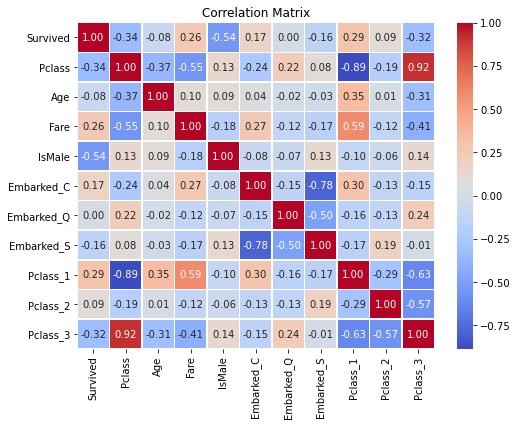

In [12]:
# correlation matrix
def create_correl_matrix(df, title):
    matrix = df.corr()
    plt.figure(figsize=(8,6))
    sns.heatmap(matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
    plt.title(title)
    plt.show()
    
create_correl_matrix(df, 'Correlation Matrix')

* Passengers were more likely to pay more when embarking from C
* Fare and class were strongly correlated
* Sex and class correlated with survivability
* Age not correlated with survivability, which is surprising

Stratify correlation by class and sex to see if there are hidden correlations with survivability

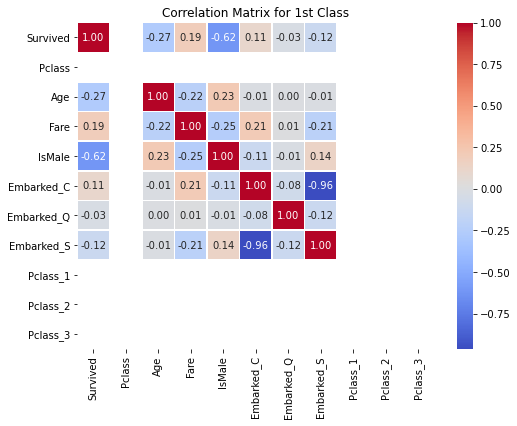

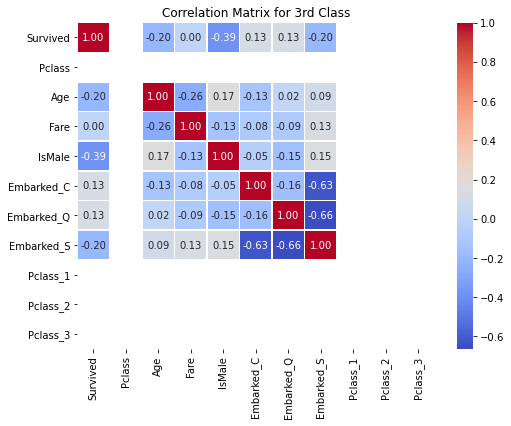

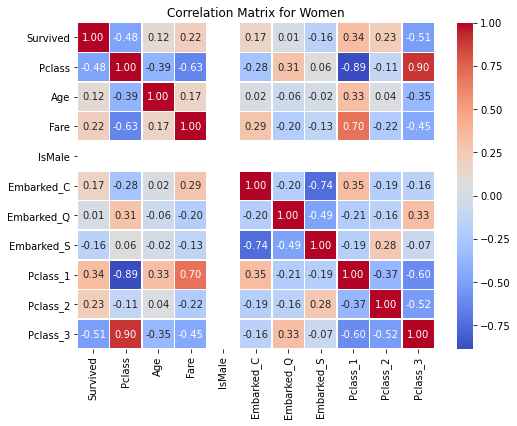

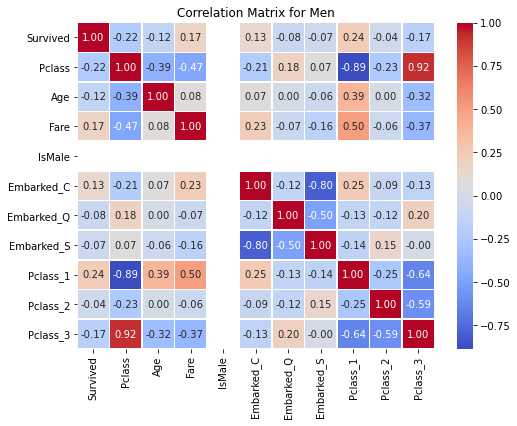

In [13]:
# stratify the data by class and sex and see if this reveals any other correlations
create_correl_matrix(df[df['Pclass_1'] == 1], 'Correlation Matrix for 1st Class')
create_correl_matrix(df[df['Pclass_3'] == 1], 'Correlation Matrix for 3rd Class')
create_correl_matrix(df[df['IsMale'] == 0], 'Correlation Matrix for Women')
create_correl_matrix(df[df['IsMale'] == 1], 'Correlation Matrix for Men')

* Age is more strongly correlated with survivability when looking only at 1st or 3rd class passengers. Hypothesis: Class is a stronger predictor of survivability than age, and combining classes muddies the waters. But within each class, children were prioritized.
* Sex is less strongly correlated with survivability when looking at only 1st or 3rd class passengers. Hypothesis: Women were prioritized over men, regardless of class.
* No additional correlations found when splitting by sex

Which features to include?
* Class and sex should clearly be included in the model.
* Should we use class, or will the highly correlated attribute Fare yield a better result?
* The original Pclass variable is more categorical than linear, but there's an argument than it's somewhat linear; try both.
* Age seems to play a factor, but is not as strong as class or sex.

In [23]:
# try different sets of features
features_0 = ['Age', 'Pclass', 'IsMale']
features_1 = ['Age', 'Fare', 'IsMale']
features_2 = ['Age', 'Pclass_1', 'Pclass_3', 'IsMale']
features_3 = ['Pclass_1', 'Pclass_3', 'IsMale']
features_4 = ['IsMale']
target = ['Survived']

### Logistic Regression Model

Using default hyperparameters; no reason to change them.

In [64]:
def eval_model(df, features, target, incl_conf_matrix=False):
    print('\n*** Model with features ' + str(features) + '***')
    
    # split into train/test sets
    df = df[features + target].dropna(how='any')
    X = df[features]
    y = df[target[0]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=16)
    
    # instantiate the model
    logreg = LogisticRegression(random_state=16)

    # fit the model with data
    logreg.fit(X_train, y_train)
    
    # get the coefficients and influence of each feature
    print('Weights: ', np.round(logreg.coef_, 2))
    print('Influence: ', np.round(np.array(np.std(X, 0))*logreg.coef_, 2))
    
    # get the predictions
    y_pred = logreg.predict(X_test)
    
    # get the classification report
    print('Classification Report')
    print(classification_report(y_test, y_pred))
    
    # get the roc auc score
    print('ROC AUC:', np.round(roc_auc_score(y_test, y_pred), 2))
    
    # get the confusion matrix
    cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
    
    if incl_conf_matrix:
        class_names=[0, 1]
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)

        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap='YlGnBu' ,fmt='g')
        plt.tight_layout()
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')

    return y_test, y_pred, cnf_matrix, np.round(logreg.intercept_, 2)

In [65]:
y_test, y_pred, cnf_matrix, intercept = eval_model(df, features_0, target)
y_test, y_pred, cnf_matrix, intercept = eval_model(df, features_1, target)
y_test, y_pred, cnf_matrix, intercept = eval_model(df, features_2, target)
y_test, y_pred, cnf_matrix, intercept = eval_model(df, features_3, target)
y_test, y_pred, cnf_matrix, intercept = eval_model(df, features_4, target)


*** Model with features ['Age', 'Pclass', 'IsMale']***
Weights:  [[-0.03 -1.23 -2.39]]
Influence:  [[-0.49 -1.03 -1.15]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.86      0.83       102
           1       0.80      0.73      0.76        77

    accuracy                           0.80       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.80      0.80      0.80       179

ROC AUC: 0.8

*** Model with features ['Age', 'Fare', 'IsMale']***
Weights:  [[-0.01  0.01 -2.24]]
Influence:  [[-0.13  0.68 -1.08]]
Classification Report
              precision    recall  f1-score   support

           0       0.77      0.83      0.80       102
           1       0.75      0.68      0.71        77

    accuracy                           0.77       179
   macro avg       0.76      0.75      0.76       179
weighted avg       0.76      0.77      0.76       179

ROC AUC: 0.75

*** Model with features ['Age', 

The model using sex, age, and the re-coded class yields the best F1 score and ROC AUC.


*** Model with features ['Age', 'Pclass_1', 'Pclass_3', 'IsMale']***
Weights:  [[-0.03  1.22 -1.19 -2.38]]
Influence:  [[-0.48  0.54 -0.59 -1.15]]
Classification Report
              precision    recall  f1-score   support

           0       0.81      0.86      0.84       102
           1       0.80      0.74      0.77        77

    accuracy                           0.81       179
   macro avg       0.81      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179

ROC AUC: 0.8


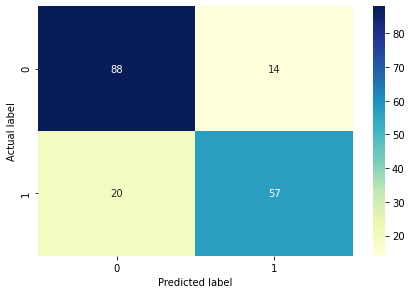

In [66]:
# run the model with the best features
y_test, y_pred, cnf_matrix, intercept = eval_model(df, features_2, target, incl_conf_matrix=True)

The model using sex, age, and the re-coded class is 81% accurate.

Sex is the most influential factor on the prediction. Class and age are about half as influential.

The model is better at correctly predicting non-survivors than survivors, failing to correctly predict a survivor status in 38% of cases.

### Logistic Regression Model, stratifying on class

In [41]:
# choose features and stratifications
features_5 = ['Age', 'IsMale']
features_6 = ['IsMale']

df_class1 = df[df['Pclass_1'] == 1]
df_class2 = df[df['Pclass_2'] == 1]
df_class3 = df[df['Pclass_3'] == 1]

In [57]:
# function to calculate accuracy for mixed models
def calc_blended_accuracy(cfn_matrices):
    tn = 0
    fp = 0
    fn = 0
    tp = 0
    
    for m in cfn_matrices:
        tn += m[0][0]
        fp += m[0][1]
        fn += m[1][0]
        tp += m[1][1]
        
#     p = tp/(tp + fp)
#     r = tp/(tp + fn)
#     f1 = 2*((p*r)/(p + r))

    accuracy = (tp + tn) / (tp + tn + fp + fn)
    
    return accuracy

In [69]:
y_test, y_pred, cnf_matrix_1, intercept = eval_model(df_class1, features_5, target)
y_test, y_pred, cnf_matrix_2, intercept = eval_model(df_class2, features_5, target)
y_test, y_pred, cnf_matrix_3, intercept = eval_model(df_class3, features_5, target)
accuracy = calc_blended_accuracy([cnf_matrix_1, cnf_matrix_2, cnf_matrix_3])
print('\n*** Blended Model Accuracy: ', np.round(accuracy, 2), '***')

y_test, y_pred, cnf_matrix_1, intercept_1 = eval_model(df_class1, features_6, target)
y_test, y_pred, cnf_matrix_2, intercept_2 = eval_model(df_class2, features_6, target)
y_test, y_pred, cnf_matrix_3, intercept_3 = eval_model(df_class3, features_6, target)
accuracy = calc_blended_accuracy([cnf_matrix_1, cnf_matrix_2, cnf_matrix_3])
print('\n*** Blended Model Accuracy: ', np.round(accuracy, 2), '***')


*** Model with features ['Age', 'IsMale']***
Weights:  [[-0.04 -2.91]]
Influence:  [[-0.53 -1.45]]
Classification Report
              precision    recall  f1-score   support

           0       0.42      0.50      0.45        10
           1       0.86      0.81      0.83        37

    accuracy                           0.74        47
   macro avg       0.64      0.66      0.64        47
weighted avg       0.76      0.74      0.75        47

ROC AUC: 0.66

*** Model with features ['Age', 'IsMale']***
Weights:  [[-0.06 -3.35]]
Influence:  [[-0.84 -1.66]]
Classification Report
              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.96      0.96      0.96        24

    accuracy                           0.95        44
   macro avg       0.95      0.95      0.95        44
weighted avg       0.95      0.95      0.95        44

ROC AUC: 0.95

*** Model with features ['Age', 'IsMale']***
Weights:  [[-0.05 -1.26]]
In

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


The model yields a higher accuracy -- 83% -- when I stratify the data set by class, then run a separate model on each class, taking only sex into account.

In [70]:
# get intercepts for the best model
print('Intercepts: ', intercept_1, intercept_2, intercept_3)

Intercepts:  [2.46] [1.72] [-0.01]


In [ ]:

from sklearn.ensemble import RandomForestClassifier

y = train_data["Survived"]

features = ["Pclass", "Sex", "SibSp", "Parch"]
X = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X, y)
predictions = model.predict(X_test)

output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': predictions})
# output.to_csv('submission.csv', index=False)
# print("Your submission was successfully saved!")

In [ ]:
output